<b>TP : k-plus proches voisins, analyse discriminante linéaire et régression logistique</b>
<br>Mohamed SANAD

# Importation des paquets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances
from collections import Counter
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate
from sklearn import datasets
from matplotlib.pyplot import figure
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.base import BaseEstimator, ClassifierMixin

# Définitions et notations

On rappelle ici le cadre de la classification supervisée, et l’on présente les notations que l’on utilisera
dans la suite. Il est à noter que pour ce TP on considère un cadre plus général qu’au TP précédent : le
nombre de classes peut-être plus grand que deux.

➣ Y est l’ensemble des étiquettes des données (labels en anglais). Ici on raisonne avec un nombre L
quelconque de classes, et l’on choisit Y = {1, . . . , L} pour représenter les L étiquettes possibles (le
cas de la classification binaire est le cas où L = 2).

➣ x = ${(x1, . . . , xp)}^{T}$ ∈ X ⊂ ${R}^{p}$ est une observation, un exemple, un point (ou un sample en anglais).
La jème coordonnée de x est la valeur prise par la jème variable (feature en anglais).

➣ ${D}_{n}$ = {(${x}_{i}$, ${y}_{i}$), i = 1, . . . n} est l’ensemble d’apprentissage contenant les n exemples et leurs étiquettes.

➣ Il existe un modèle probabiliste qui gouverne la génération de nos observations selon des variables
aléatoires X et Y : ∀i ∈ {1, . . . , n}, (${x}_{i}$, ${y}_{i}$) ∼ (X, Y).

➣ On cherche à construire à partir de l’ensemble d’apprentissage ${D}_{n}$ une fonction appelée classifieur,
${\hat {f}}$ : X → Y qui à un nouveau point ${x}_{new}$ associe une étiquette ${\hat {f}}$(${x}_{new}$).

# Génération artificielle de données

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les
visualiser facilement) à savoir p = 2 dans le formalisme ci-dessus. On reprend en partie les jeux de
données artificiels du TP sur le perceptron, avec certaines modifications.

### Question 1 : 

Étudiez les fonctions <b>rand_bi_gauss</b>, <b>rand_tri_gauss</b>, <b>rand_clown</b> et <b>rand_checkers</b>. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ?

In [2]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)

In [3]:
def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [4]:
def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]

In [5]:
def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [6]:
def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

Générez les données en utilisant chacune de ces 4 fonctions avec les valeurs des paramètres suivantes :

➣ Pour <b>rand_bi_gauss</b>, prenez 20 observations dans chaque classe, centrées en ${(1, 1)}^{T}$ et
${(-1, -1)}^{T}$, tous les écart-types égaux à 0.9.

➣ Pour <b>rand_tri_gauss</b>, prenez 50 observations dans chaque classe, centrées en ${(1, 1)}^{T}$, ${(-1, -1)}^{T}$ et
${(1, -1)}^{T}$, tous les écart-types égaux à 0.9.

➣ Pour <b>rand_clown</b>, prenez 50 pour les deux premiers arguments et 1 et 5 pour les deux suivants.

➣ Pour <b>rand_checkers</b>, prenez 150 pour les deux premiers arguments et laissez le troisième par
défaut.

In [7]:
dataset_1 = rand_bi_gauss(n1=20, n2=20, 
                          mu1=[1, 1], mu2=[-1, -1], 
                          sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

dataset_2 = rand_tri_gauss(n1=50, n2=50, n3=50, 
                           mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1], 
                           sigma1=[0.9, 0.9], sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

dataset_3 = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

dataset_4 = rand_checkers(n1=150, n2=150, sigma=0.1)

print("Dataset 1 :")
print("Shape of X = "+str(dataset_1[0].shape))
print("Shape of Y = "+str(dataset_1[1].shape))
print("\nDataset 2 :")
print("Shape of X = "+str(dataset_2[0].shape))
print("Shape of Y = "+str(dataset_2[1].shape))
print("\nDataset 3 :")
print("Shape of X = "+str(dataset_3[0].shape))
print("Shape of Y = "+str(dataset_3[1].shape))
print("\nDataset 4 :")
print("Shape of X = "+str(dataset_4[0].shape))
print("Shape of Y = "+str(dataset_4[1].shape))

Dataset 1 :
Shape of X = (40, 2)
Shape of Y = (40,)

Dataset 2 :
Shape of X = (150, 2)
Shape of Y = (150,)

Dataset 3 :
Shape of X = (100, 2)
Shape of Y = (100,)

Dataset 4 :
Shape of X = (288, 2)
Shape of Y = (288,)


### Question 2 :

Utilisez la fonction <b>plot_2d</b> afin d’afficher les jeux de données générés avec chacune des fonctions.

In [8]:
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

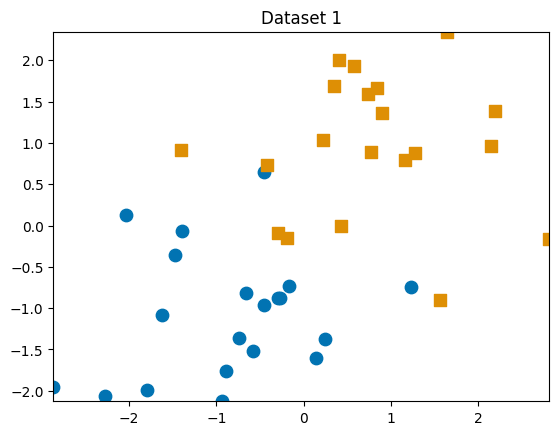

In [9]:
plt.title('Dataset 1')
plot_2d(dataset_1[0], dataset_1[1])

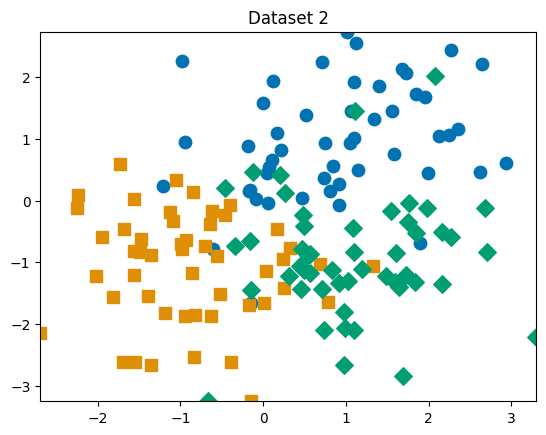

In [10]:
plt.title('Dataset 2')
plot_2d(dataset_2[0], dataset_2[1])

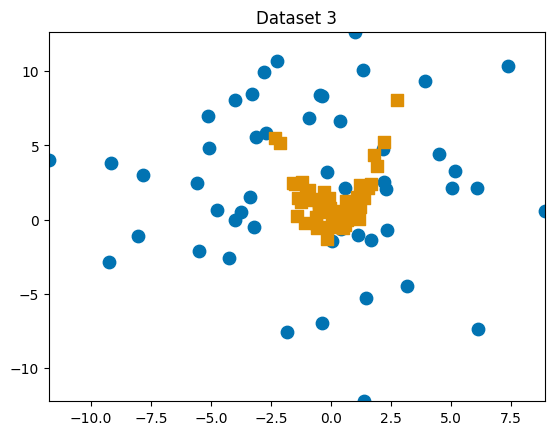

In [11]:
plt.title('Dataset 3')
plot_2d(dataset_3[0], dataset_3[1])

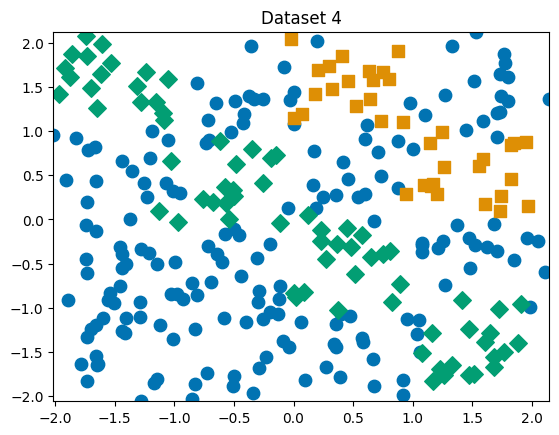

In [12]:
plt.title('Dataset 4')
plot_2d(dataset_4[0], dataset_4[1])

# La méthode des k-plus proches voisins

## Approche intuitive

L’algorithme des k-plus proches voisins (k-nn : pour <i>k-nearest neighbors</i> en anglais) est un algorithme
intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque
d’étiquettes.

Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point x on commence
par déterminer l’ensemble de ses k-plus proches voisins parmi les points d’apprentissage que l’on note
${V}_{k}(x)$ (bien sûr on doit choisir 1 ≤ k ≤ n pour que cela ait un sens). La classe que l’on affecte au nouveau
point x est alors la classe majoritaire dans l’ensemble ${V}_{k}(x)$.

### Question 3 :

Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y
sont à valeurs réelles : Y = R.

Lorsque les observations sont à valeurs réelles, on peut penser à affecter, pour un nouveau point x, la moyenne des yi de ses k-plus proches voisins.

## Approche formelle

### Question 4 :

Écrivez votre propre classe <b>KNNClassifier</b> avec les méthodes d’apprentissage fit et de classification
predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même
distance ou le même nombre de points de chaque classe dans ${V}_{k}(x)$. 

In [13]:
class KNNClassifier:
    
    def __init__(self, n_neighbors=1):
        self.k = n_neighbors
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        self.X_test = X
        # dist est une matrice (n x m) tq :
        # n = nombre d'observations dans le set de test
        # m = nombre d'observations dans le set d'apprentissage
        # dist[i,j] = distance euclidienne entre le ième point du set de test et le jème point du set d'apprentissage
        dist = pairwise_distances(self.X_test, self.X_train, metric='euclidean')
        # Pour chaque observation dans le set de test, on donne les classes des k plus proches voisins du set d'apprentissage
        k_nn = self.y_train[dist.argsort()[:,:self.k].reshape(-1)].reshape(-1,self.k)
        # Pour chaque observation dans le set de test, on détermine la classe majoritaire parmi ces k plus proches voisins
        # Traitement des ex aequo (voir la cellule suivante)
        classes = np.array([])
        for i in range(len(self.X_test)):
            classes = np.append(classes, Counter(k_nn[i]).most_common(1)[0][0])
        return classes
    
    def score(self, X, y):
        self.X_test = X
        self.y_test = y
        y_pred = self.predict(self.X_test)
        accuracy = np.sum(y_pred == self.y_test) / len(self.y_test)
        return accuracy

Pour le traitement des ex aequo, c'est-à-dire lorsque plusieurs classes sont majoritaires et non pas une seule, on sélectionne celle qu'on rencontre en premier lorsqu'on sélectionne les plus proches voisins l'un après l'autre. Ceci est possible avec la fonction Counter().most_common(1) :

In [14]:
Counter(np.array([4,3,1,2,2,1,2,2,1,1,3])).most_common(1)
# Classe 1 ==> Nombre d'occurences = 4
# Classe 2 ==> Nombre d'occurences = 4
# Classe 3 ==> Nombre d'occurences = 2
# Classe 4 ==> Nombre d'occurences = 1

[(1, 4)]

Dans cet exemple, chacune des classes 1 et 2 est présente 4 fois, mais notre fonction a choisi d'afficher uniquement la classe 1. Essayons maintenant de permuter les éléments d'indices 2 et 3 dans l'array ci-dessus :

In [15]:
Counter(np.array([4,3,2,1,2,1,2,2,1,1,3])).most_common(1)
# Classe 1 ==> Nombre d'occurences = 4
# Classe 2 ==> Nombre d'occurences = 4
# Classe 3 ==> Nombre d'occurences = 2
# Classe 4 ==> Nombre d'occurences = 1

[(2, 4)]

Ainsi, cette fonction opte toujours pour la première classe rencontrée (parmi les classes majoritaires). Ceci nous est utile car si :

x = le plus proche voisin appartenant à la classe i

y = le plus proche voisin appartenant à la classe j

avec i,j = classes majoritaires

Alors, rencontrer i avant j signifie que x est plus proche de notre observation (du set de test) que y.

Vérifier la validité des résultats
en les comparant à ceux de la classe <b>KNeighborsClassifier</b> de scikit-learn en utilisant le jeu de
données #2.

In [16]:
X_train = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==0]]
X_test = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==1]]
y_train = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==0]]
y_test = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==1]]

In [17]:
# KNNClassifier()
knn_classifier = KNNClassifier(n_neighbors=4)
knn_classifier.fit(X_train, y_train)
knn_classifier.score(X_test, y_test)

0.7866666666666666

In [18]:
# KNeighborsClassifier()
knn = neighbors.KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8

In [19]:
np.all(knn_classifier.predict(X_test) == knn.predict(X_test))

False

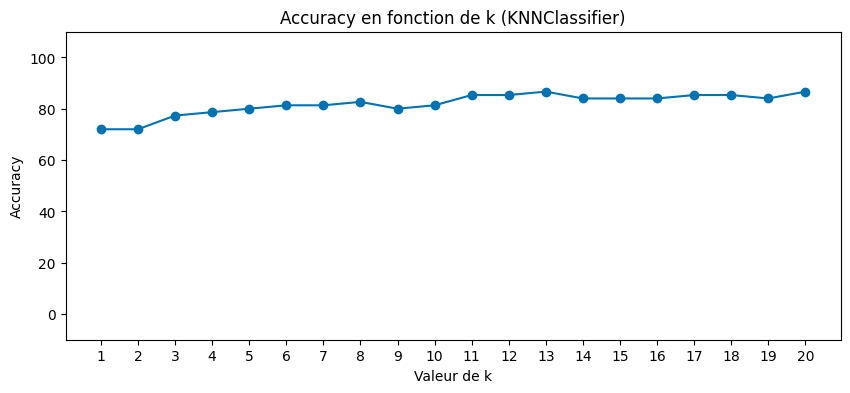

In [20]:
performances = []
for k in range(1,21):
    knn_classifier = KNNClassifier(n_neighbors=k)
    performances.append(100* knn_classifier.fit(X_train, y_train).score(X_test, y_test))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 4)
ax.plot(range(1,21), performances, 'o-')
ax.set_title("Accuracy en fonction de k (KNNClassifier)")
ax.set_xlabel("Valeur de k")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,21))
ax.set_ylim([-10, 110])
plt.show()

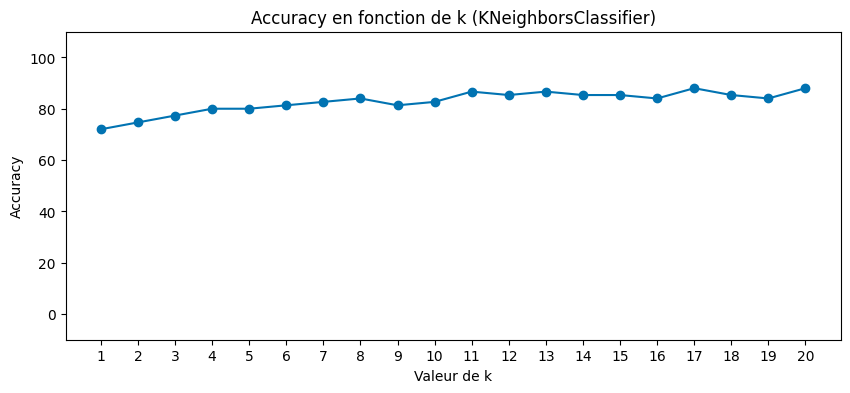

In [21]:
performances = []
for k in range(1,21):
    knn = neighbors.KNeighborsClassifier(k)
    performances.append(100* knn.fit(X_train, y_train).score(X_test, y_test))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 4)
ax.plot(range(1,21), performances, 'o-')
ax.set_title("Accuracy en fonction de k (KNeighborsClassifier)")
ax.set_xlabel("Valeur de k")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,21))
ax.set_ylim([-10, 110])
plt.show()

In [22]:
for k in range(1,21):
    knn_classifier = KNNClassifier(n_neighbors=k)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    print("k = "+str(k)+"\t: "+str(np.all(knn_classifier.predict(X_test) == knn.predict(X_test))))

k = 1	: True
k = 2	: False
k = 3	: False
k = 4	: False
k = 5	: False
k = 6	: True
k = 7	: False
k = 8	: False
k = 9	: False
k = 10	: False
k = 11	: False
k = 12	: True
k = 13	: True
k = 14	: False
k = 15	: False
k = 16	: True
k = 17	: False
k = 18	: True
k = 19	: True
k = 20	: False


Les résultats sont proches mais pas identiques à ceux obtenus avec la classe <b>KNeighborsClassifier</b> de scikit-learn. Cela est dû probablement à la manière avec laquelle on a traité les ex aequo qui diffère de celle utilisée dans <b>KNeighborsClassifier</b>.

### Question 5 :

Pour gagner en temps de calcul, vous utiliserez à partir de maintenant l’implémentation de scikit-learn.

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant
la distance euclidienne classique $d(x, v) = {||x − v||}^{2}$ et k = 5. Visualisez les règles de classification
obtenues en utilisant la fonction <b>frontiere_new</b>.

In [23]:
def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()

In [24]:
def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True, samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

➤ dataset_1 :

In [25]:
knn_1 = neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_1.fit(dataset_1[0], dataset_1[1])
knn_1.score(dataset_1[0], dataset_1[1])

0.95

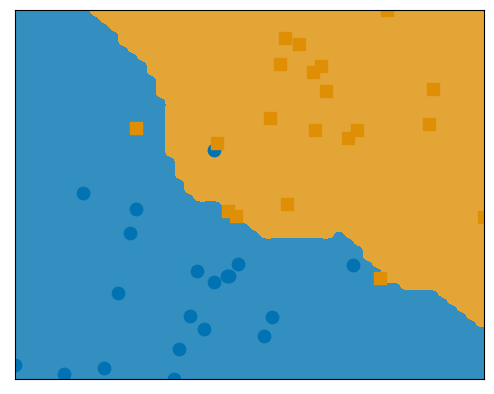

In [26]:
def f_(X):
    return knn_1.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_1[0], dataset_1[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

➤ dataset_2 :

In [27]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_2.fit(dataset_2[0], dataset_2[1])
knn_2.score(dataset_2[0], dataset_2[1])

0.8733333333333333

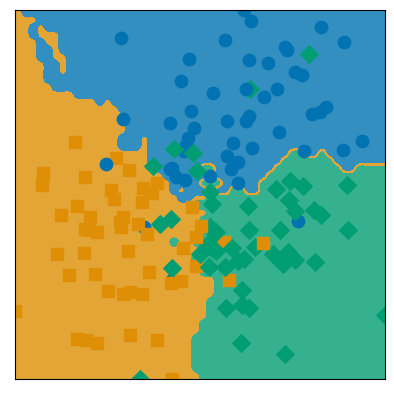

In [28]:
def f_(X):
    return knn_2.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_2[0], dataset_2[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

➤ dataset_3 :

In [29]:
knn_3 = neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_3.fit(dataset_3[0], dataset_3[1])
knn_3.score(dataset_3[0], dataset_3[1])

0.9

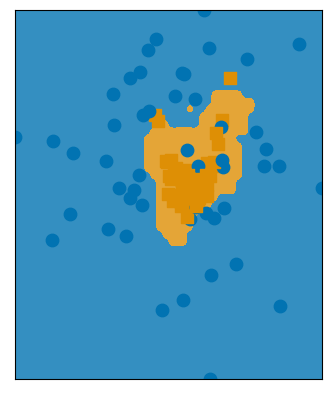

In [30]:
def f_(X):
    return knn_3.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_3[0], dataset_3[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

➤ dataset_4 :

In [31]:
knn_4 = neighbors.KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_4.fit(dataset_4[0], dataset_4[1])
knn_4.score(dataset_4[0], dataset_4[1])

0.9270833333333334

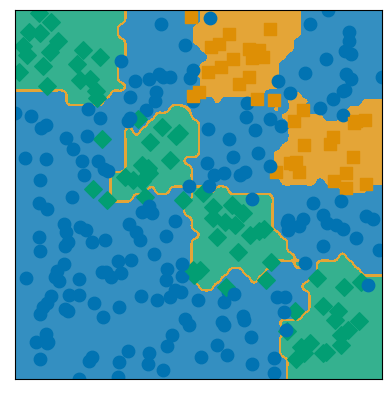

In [32]:
def f_(X):
    return knn_4.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_4[0], dataset_4[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

### Question 6 :

Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris
en compte : k = 1, 2, . . . , n.

In [33]:
X_train = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==0]]
X_test = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==1]]
y_train = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==0]]
y_test = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==1]]

In [34]:
n = len(y_train)

performances = [] # Sur les données de test
errors = [] # Sur les données de test

for k in range(1,n+1):
    knn = neighbors.KNeighborsClassifier(k)
    performances.append(100* knn.fit(X_train, y_train).score(X_test, y_test))
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))

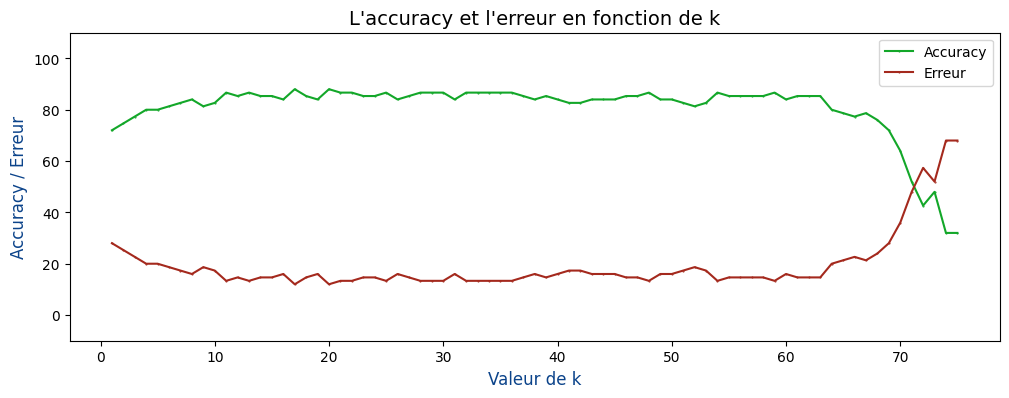

In [35]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)
ax.plot(range(1,n+1), performances, marker=".", markersize=1, color="#13A729", label="Accuracy")
ax.plot(range(1,n+1), errors, marker=".", markersize=1, color="#A4291D", label="Erreur")
ax.set_title("L'accuracy et l'erreur en fonction de k", fontsize=14)
ax.set_xlabel("Valeur de k", fontsize=12, color="#0B438A")
ax.set_ylabel("Accuracy / Erreur", fontsize=12, color="#0B438A")
ax.set_ylim([-10, 110])
ax.legend()
plt.show()

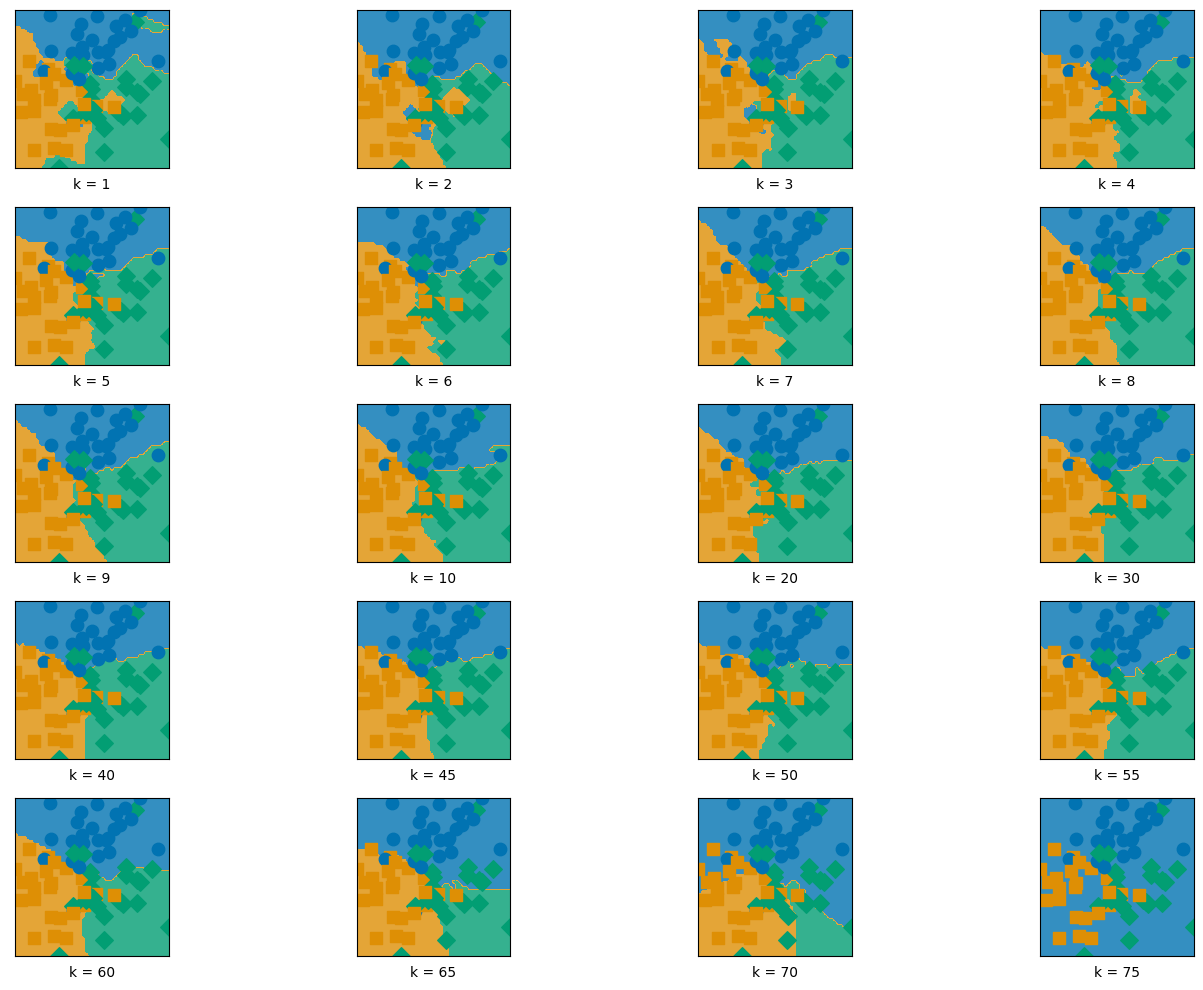

In [36]:
plt.figure(figsize=(15, 10))

for i,k in enumerate([1,2,3,4,5,6,7,8,9,10,20,30,40,45,50,55,60,65,70,75]):
    knn = neighbors.KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    
    def f_(X):
        return knn.predict(X.reshape(1,-1))
    
    plt.subplot(5, 4, i+1)
    plt.xlabel('k = '+str(k), fontsize=10)
    frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

plt.tight_layout()

Que devient la méthode dans le cas extrême où k = 1 ? k = n ?

➤ <b>k = 1 :</b> Dans ce cas, on affecte la classe du plus proche voisin.

In [37]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1, metric='euclidean')
print("Accuracy = "+str(round(knn.fit(X_train, y_train).score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn.fit(X_train, y_train).score(X_test, y_test),2)))

Accuracy = 0.72
Erreur = 0.28


In [38]:
metrics = precision_recall_fscore_support(y_test, knn.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.826087    0.689655    0.652174
Recall        0.791667    0.769231    0.6
F1-score      0.808511    0.727273    0.625
Support      24          26          25


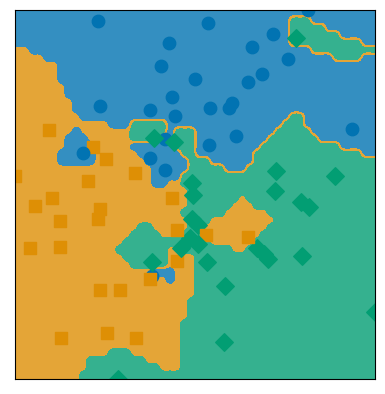

In [39]:
def f_(X):
    return knn.predict(X.reshape(1,-1))

frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

➤ <b>k = n :</b> Dans ce cas, on affecte la classe majoritaire dans le set d'entrainement.

In [40]:
knn = neighbors.KNeighborsClassifier(n_neighbors=n, metric='euclidean')
print("Accuracy = "+str(round(knn.fit(X_train, y_train).score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn.fit(X_train, y_train).score(X_test, y_test),2)))

Accuracy = 0.32
Erreur = 0.68


In [41]:
metrics = precision_recall_fscore_support(y_test, knn.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.32               0           0
Recall        1                  0           0
F1-score      0.484848           0           0
Support      24                 26          25


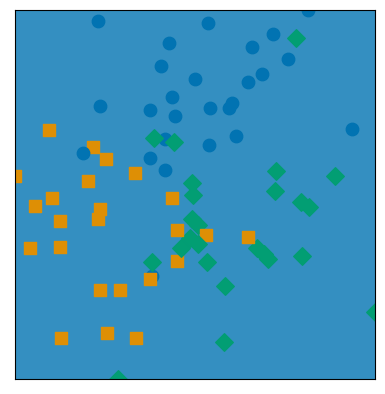

In [42]:
def f_(X):
    return knn.predict(X.reshape(1,-1))

frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

Dans quels cas la frontière est-elle complexe ? simple ?

➤ <b>Lorsque k = 1 :</b> La frontière est complexe, on prédit très bien sur les données d'apprentissage mais pas bien sur les nouvelles données.

➜ <i>Sur-apprentissage (Overfitting)</i>

➤ <b>Lorsque k = n :</b> La frontière est simple, on ne prédit pas bien ni sur les données d'apprentissage ni sur les nouvelles données.

➜ <i>On prédit la classe majoritaire globale</i>

### Question 7 :

Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon ${e}^{-{{d}_{j}}^{2} / h}$ (h contrôlant le niveau de pondération).

Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur de KNeighborsClassifier.

Pour tester l’impact du choix de h sur les frontières de classification, visualisez les règles de classification pour k = 7 et h = ${10}^{j}$ avec j = −2, −1, 0, 1, 2 ; utilisez les observations d’indice pair du jeux de données #2 pour l’entrainement du classifieur

In [43]:
X_train = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==0]]
X_test = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==1]]
y_train = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==0]]
y_test = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==1]]

➤ $h = {10}^{-2} :$

In [44]:
def weights_func(dist):
    h = 10**(-2)
    return np.exp(-(dist**2)/h)

In [45]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
knn_2.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_2.score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn_2.score(X_test, y_test),2)))

Accuracy = 0.72
Erreur = 0.28


In [46]:
metrics = precision_recall_fscore_support(y_test, knn_2.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.826087    0.689655    0.652174
Recall        0.791667    0.769231    0.6
F1-score      0.808511    0.727273    0.625
Support      24          26          25


➤ $h = {10}^{-1} :$

In [47]:
def weights_func(dist):
    h = 10**(-1)
    return np.exp(-(dist**2)/h)

In [48]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
knn_2.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_2.score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn_2.score(X_test, y_test),2)))

Accuracy = 0.79
Erreur = 0.21


In [49]:
metrics = precision_recall_fscore_support(y_test, knn_2.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.904762    0.785714    0.692308
Recall        0.791667    0.846154    0.72
F1-score      0.844444    0.814815    0.705882
Support      24          26          25


➤ $h = 1 :$

In [50]:
def weights_func(dist):
    return np.exp(-(dist**2))

In [51]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
knn_2.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_2.score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn_2.score(X_test, y_test),2)))

Accuracy = 0.81
Erreur = 0.19


In [52]:
metrics = precision_recall_fscore_support(y_test, knn_2.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.9         0.851852    0.714286
Recall        0.75        0.884615    0.8
F1-score      0.818182    0.867925    0.754717
Support      24          26          25


➤ $h = 10 :$

In [53]:
def weights_func(dist):
    h = 10
    return np.exp(-(dist**2)/h)

In [54]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
knn_2.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_2.score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn_2.score(X_test, y_test),2)))

Accuracy = 0.81
Erreur = 0.19


In [55]:
metrics = precision_recall_fscore_support(y_test, knn_2.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.9         0.851852    0.714286
Recall        0.75        0.884615    0.8
F1-score      0.818182    0.867925    0.754717
Support      24          26          25


➤ $h = {10}^{2} :$

In [56]:
def weights_func(dist):
    h = 10**(2)
    return np.exp(-(dist**2)/h)

In [57]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
knn_2.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_2.score(X_test, y_test),2)))
print("Erreur = "+str(round(1 - knn_2.score(X_test, y_test),2)))

Accuracy = 0.81
Erreur = 0.19


In [58]:
metrics = precision_recall_fscore_support(y_test, knn_2.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], metrics[i][0], metrics[i][1], metrics[i][2]] for i in range(4)], 
               headers=['Métrique','Classe 1','Classe 2','Classe 3']))

Métrique      Classe 1    Classe 2    Classe 3
----------  ----------  ----------  ----------
Precision     0.9         0.851852    0.714286
Recall        0.75        0.884615    0.8
F1-score      0.818182    0.867925    0.754717
Support      24          26          25


<b>L'impact du choix de h sur les frontières de classification :</b>

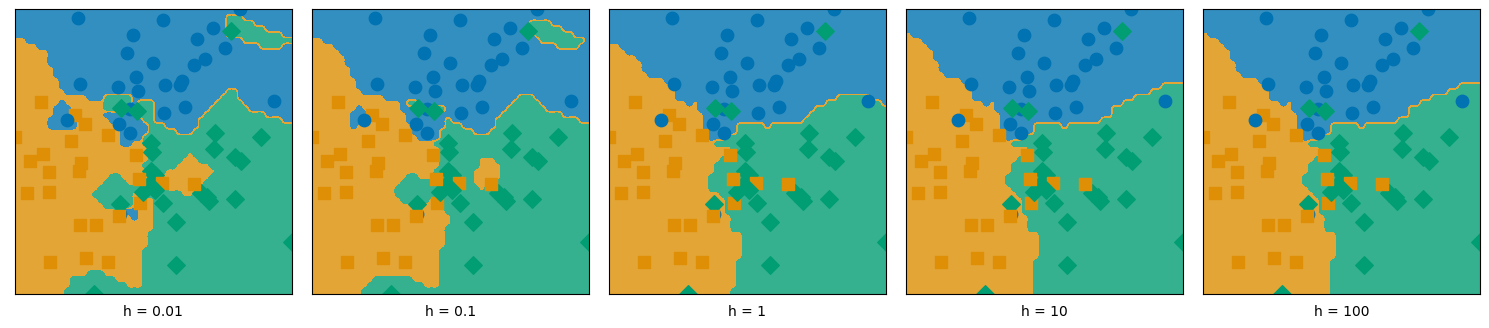

In [59]:
plt.figure(figsize=(15, 10))

for i,h in enumerate([0.01, 0.1, 1, 10, 100]):
    
    def weights_func(dist):
        return np.exp(-(dist**2)/h)
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights=weights_func)
    knn.fit(X_train, y_train)
    
    def f_(X):
        return knn.predict(X.reshape(1,-1))
    
    plt.subplot(1, 5, i+1)
    plt.xlabel('h = '+str(h), fontsize=10)
    frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

plt.tight_layout()

### Question 8 :

Quel est le taux d’erreur sur les mêmes données d’apprentissage lorsque k = 1 ? et sur des données de test ?

In [60]:
X_train = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==0]]
X_test = dataset_2[0][[i for i in range(len(dataset_2[0])) if i%2==1]]
y_train = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==0]]
y_test = dataset_2[1][[i for i in range(len(dataset_2[1])) if i%2==1]]

In [61]:
knn_2 = neighbors.KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_2.fit(X_train, y_train)
print("Taux d'erreur sur les données d'apprentissage = "+str(round(1 - knn_2.score(X_train, y_train),4)))
print("Taux d'erreur sur les données de test = "+str(round(1 - knn_2.score(X_test, y_test),4)))

Taux d'erreur sur les données d'apprentissage = 0.0
Taux d'erreur sur les données de test = 0.28


➜ <i>Overfitting</i>

### Question 9 :

Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50.
Vous pourrez utiliser la classe fournie ErrorCurve.

In [62]:
X_train = dataset_4[0][[i for i in range(len(dataset_4[0])) if i%2==0]]
X_test = dataset_4[0][[i for i in range(len(dataset_4[0])) if i%2==1]]
y_train = dataset_4[1][[i for i in range(len(dataset_4[1])) if i%2==0]]
y_test = dataset_4[1][[i for i in range(len(dataset_4[1])) if i%2==1]]

In [63]:
class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))

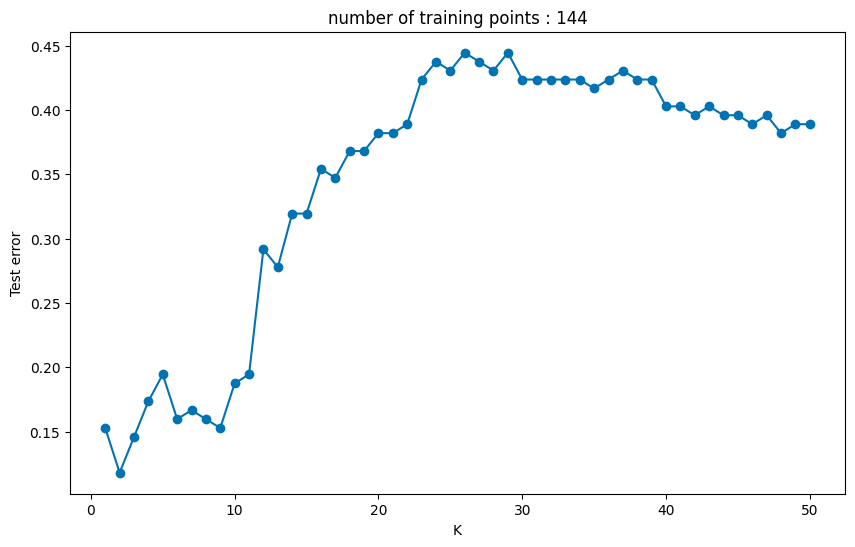

In [64]:
figure(figsize=(10, 6))
courbe = ErrorCurve(k_range=list(range(1, 51)), weights='uniform')
courbe.fit_curve(X_train, y_train, X_test, y_test)
courbe.plot()

In [65]:
errors = []

for k in range(1,51):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    print("k = "+str(k)+"\t==> Test error = "+str(round(np.mean(knn.predict(X_test) != y_test),4)))
    errors.append(np.mean(knn.predict(X_test) != y_test))

k = 1	==> Test error = 0.1528
k = 2	==> Test error = 0.1181
k = 3	==> Test error = 0.1458
k = 4	==> Test error = 0.1736
k = 5	==> Test error = 0.1944
k = 6	==> Test error = 0.1597
k = 7	==> Test error = 0.1667
k = 8	==> Test error = 0.1597
k = 9	==> Test error = 0.1528
k = 10	==> Test error = 0.1875
k = 11	==> Test error = 0.1944
k = 12	==> Test error = 0.2917
k = 13	==> Test error = 0.2778
k = 14	==> Test error = 0.3194
k = 15	==> Test error = 0.3194
k = 16	==> Test error = 0.3542
k = 17	==> Test error = 0.3472
k = 18	==> Test error = 0.3681
k = 19	==> Test error = 0.3681
k = 20	==> Test error = 0.3819
k = 21	==> Test error = 0.3819
k = 22	==> Test error = 0.3889
k = 23	==> Test error = 0.4236
k = 24	==> Test error = 0.4375
k = 25	==> Test error = 0.4306
k = 26	==> Test error = 0.4444
k = 27	==> Test error = 0.4375
k = 28	==> Test error = 0.4306
k = 29	==> Test error = 0.4444
k = 30	==> Test error = 0.4236
k = 31	==> Test error = 0.4236
k = 32	==> Test error = 0.4236
k = 33	==> Test e

In [66]:
# k optimal : C'est la valeur de k qui minimise l'erreur sur le set de test
(np.argwhere(errors == np.amin(errors)).flatten() + 1).tolist()

[2]

### Question 10 :

Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de
données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à
1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même
taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ?

Erreur minimale pour n = 100 : 0.1094
k optimal pour n = 100 : [6, 8]


Erreur minimale pour n = 200 : 0.0875
k optimal pour n = 200 : [17]


Erreur minimale pour n = 500 : 0.1008
k optimal pour n = 500 : [5, 7]


Erreur minimale pour n = 1000 : 0.076
k optimal pour n = 1000 : [25, 34]




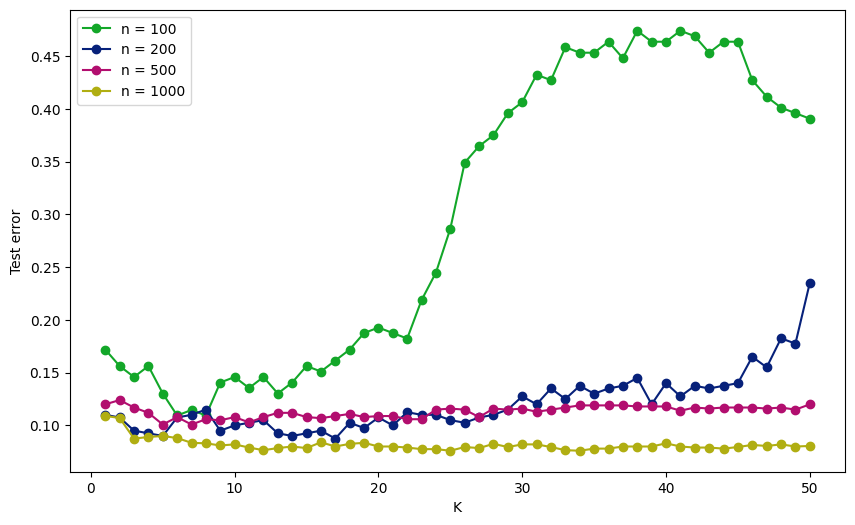

In [67]:
figure(figsize=(10, 6))

courbe = ErrorCurve(k_range=list(range(1, 51)), weights='uniform')
colors = ['#13A729', '#07217A', '#B20E6F', '#B0AE12']

for i,n in enumerate([100, 200, 500, 1000]):
    
    X_train , y_train = rand_checkers(n1=n, n2=n)
    X_test , y_test = rand_checkers(n1=n, n2=n)
    
    courbe.fit_curve(X_train, y_train, X_test, y_test)
    courbe.plot(maketitle=False, color=colors[i], label='n = '+str(n))
    
    print("Erreur minimale pour n = "+str(n)+" : "+str(round(np.amin(courbe.errors),4)))
    print("k optimal pour n = "+str(n)+" : "+str((np.argwhere(courbe.errors == np.amin(courbe.errors)).flatten() + 1).tolist()))
    print("\n")
    
plt.legend(loc='upper left')

On remarque que plus le nombre d'observations dans les échantillons d'apprentissage et de test augmente, plus l'erreur sur le set de test diminue. On remarque aussi que la meilleure valeur de k change lorsque n change aussi.

Pour n = 1000 visualisez les données et la règle de décision
sur le même graphique.

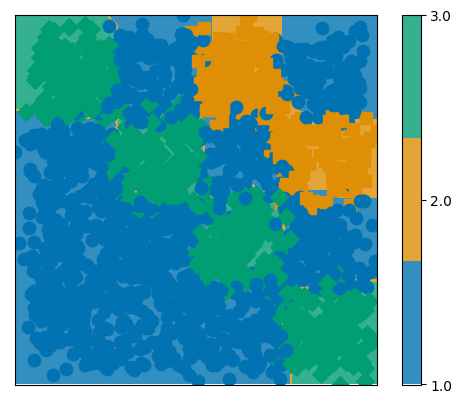

In [68]:
# k optimal pour n = 1000
k = (np.argwhere(courbe.errors == np.amin(courbe.errors)).flatten() + 1).tolist()[0]

# knn
knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train, y_train)

# Visualisation
def f_(X):
    return knn.predict(X.reshape(1,-1))

frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

### Question 11 :

A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins :
temps de calcul ? passage à l’échelle ? interprétabilité ?

✅ <b>Avantages</b> :

L'algorithme des k-plus proches voisins est facile à mettre en oeuvre, et ne requiert aucune hypothèse sur les données. De plus, il peut être utilisé pour la classification ainsi que pour la régression.

🔴 <b>Inconvénients</b> :

L'algorithme devient beaucoup plus lent à mesure que le nombre d'exemples d'apprentissage augmente. De plus, l'algorithme n'est performant que lorsqu'on dispose de beaucoup de données d'apprentissage. Un autre inconvénient est que le choix de la méthode de calcul de la distance ainsi que le nombre de voisins K peut ne pas être évident dans certains cas. Un dernier inconvénient qu'on a constaté est que l'étape de prédiction est lente (Beaucoup d'opérations : Calcul des distances, tri des distances par ordre croissant, ...).

### Question 12 :

Étudiez la base digits de scikit-learn. On pourra se référer à https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html pour le chargement et la
manipulation de la base de données. Décrivez la nature et le format des données (précisément),
affichez un exemple. 

In [69]:
digits = datasets.load_digits()

In [70]:
digits['images'].shape

(1797, 8, 8)

In [71]:
digits['data'].shape

(1797, 64)

In [72]:
digits['target'].shape

(1797,)

Chaque donnée est une image de 8 pixels par 8 pixels, en niveau de gris (256 nuances possibles), stockée sous la forme d’un vecteur de dimension 64 comme une ligne de la matrice X et avec la valeur de la classe associée stockée dans un vecteur y (digits.target) à part. Il y a 1797 images, donc X (digits.data) est de dimension 1797 x 64.

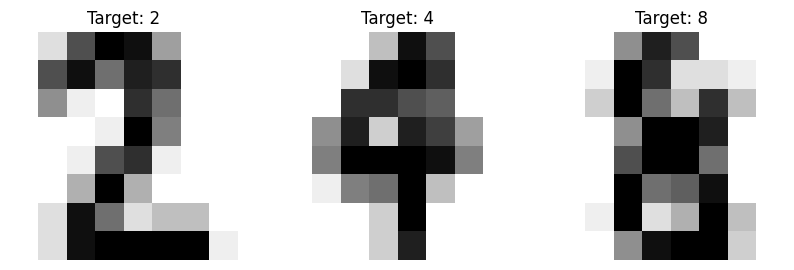

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images[[1232,687,1705]], digits.target[[1232,687,1705]]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Target: %i" % label)

Tracez l’histogramme des classes.

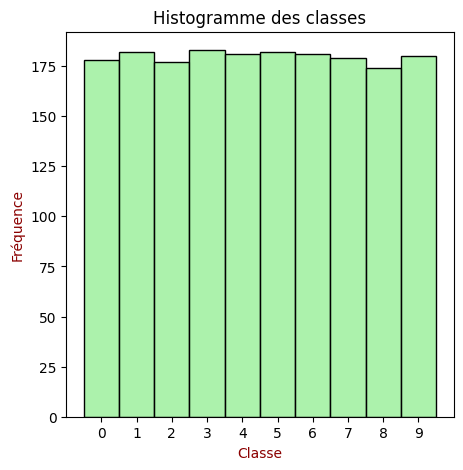

In [74]:
plt.figure(figsize=(5,5))

sns.histplot(digits.target, color='lightgreen', bins=(np.arange(11) - 0.5), stat='count')

plt.title("Histogramme des classes")
plt.xlabel('Classe', color='darkred')
plt.xlim([-1,10])
plt.xticks(list(range(10)))
plt.ylabel('Fréquence', color='darkred')

plt.show()

Coupez l’échantillon en deux parties de
même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test.

In [75]:
X = digits['data']
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, shuffle=False)

Appliquez
la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez
le taux d’erreur.

In [76]:
knn_digits = neighbors.KNeighborsClassifier(n_neighbors=30, weights='uniform')
knn_digits.fit(X_train, y_train)
print("Accuracy = "+str(round(knn_digits.score(X_test, y_test),4)))
print("Taux d'erreur = "+str(round(1 - knn_digits.score(X_test, y_test),4)))

Accuracy = 0.9255
Taux d'erreur = 0.0745


In [77]:
metrics = precision_recall_fscore_support(y_test, knn_digits.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], 
                 np.round(metrics[i][0],4), 
                 np.round(metrics[i][1],4), 
                 np.round(metrics[i][2],4),
                 np.round(metrics[i][3],4),
                 np.round(metrics[i][4],4),
                 np.round(metrics[i][5],4),
                 np.round(metrics[i][6],4),
                 np.round(metrics[i][7],4),
                 np.round(metrics[i][8],4),
                 np.round(metrics[i][9],4)]
                for i in range(4)], 
               headers=['Métrique','0','1','2','3','4','5','6','7','8','9']))

Métrique          0        1        2        3        4        5        6        7        8       9
----------  -------  -------  -------  -------  -------  -------  -------  -------  -------  ------
Precision    0.956    0.9318   0.9186   0.8265   0.9886   0.8947   0.9579   0.9263   0.9577   0.913
Recall       0.9886   0.9011   0.9186   0.8901   0.9457   0.9341   1        0.9888   0.7727   0.913
F1-score     0.9721   0.9162   0.9186   0.8571   0.9667   0.914    0.9785   0.9565   0.8553   0.913
Support     88       91       86       91       92       91       91       89       88       92


On peut aussi envisager de faire varier k entre 1 et 100 et tracer le taux d'erreur en fonction de k :

Erreur minimale = 0.0367
k optimal = [3]


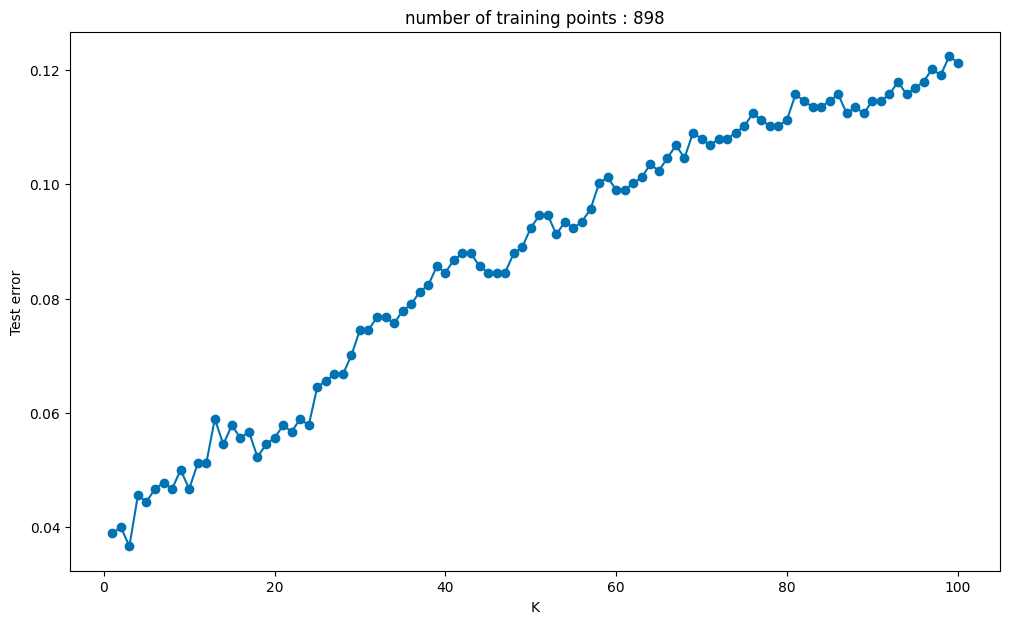

In [78]:
figure(figsize=(12, 7))
courbe = ErrorCurve(k_range=list(range(1, 101)), weights='uniform')
courbe.fit_curve(X_train, y_train, X_test, y_test)
courbe.plot()

print("Erreur minimale = "+str(round(np.amin(courbe.errors),4)))
print("k optimal = "+str((np.argwhere(courbe.errors == np.amin(courbe.errors)).flatten() + 1).tolist()))

La courbe du taux d'erreur en fonction de k possède une allure plus ou moins croissante.

### Question 13 :

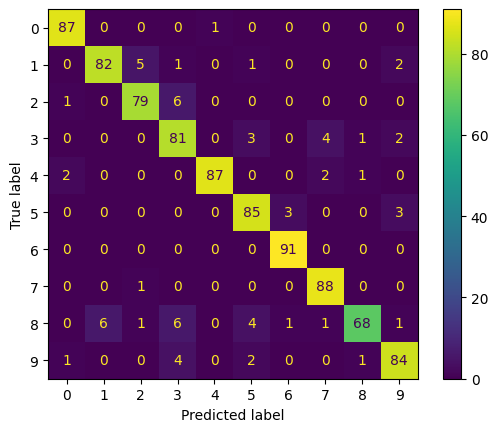

In [79]:
knn_digits = neighbors.KNeighborsClassifier(n_neighbors=30, weights='uniform')
knn_digits.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(knn_digits, X_test, y_test)

### Question 14 :

Proposez une méthode pour choisir k et mettez-la en œuvre.

In [80]:
X = digits['data']
y = digits['target']

On utilise une validation croisée avec un nombre de folds égal à 5. Pour chaque valeur de k (entre 1 et 100), on calcule le taux d'erreur moyen sur les 5 splits (dans chaque split, on sélectionne 4 folds pour l'apprentissage et 1 fold pour le test). On choisit le k qui minimise ce taux d'erreur moyen :

In [81]:
performances = []
errors = []

for k in range(1,101):
    knn_cv = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    cv_scores = cross_val_score(knn_cv, X, y, cv=5)
    mean_accuracy = np.mean(cv_scores)
    performances.append(mean_accuracy)
    errors.append(1-mean_accuracy)

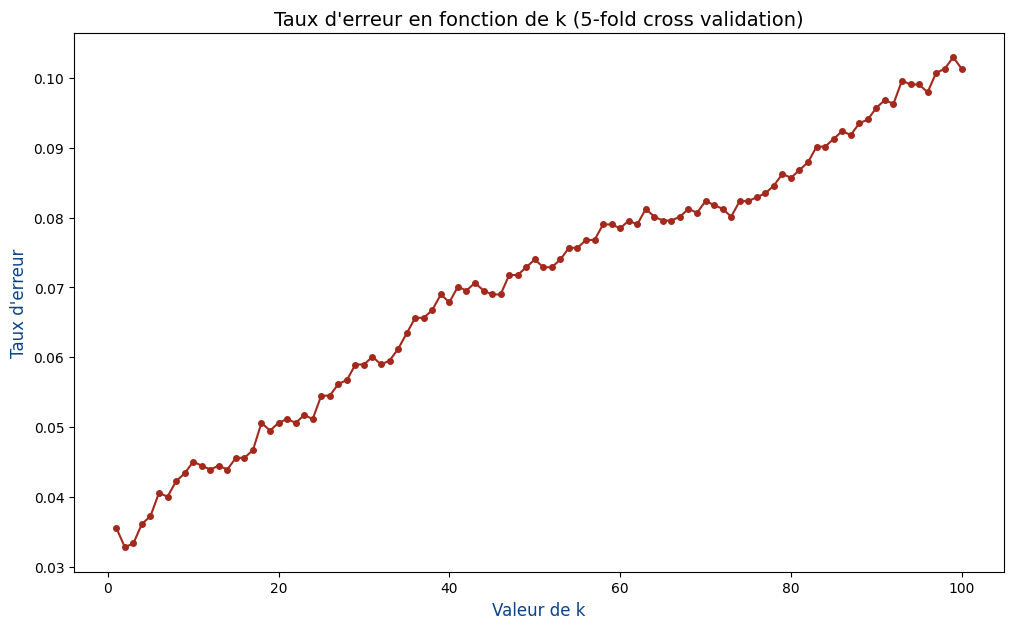

In [82]:
fig = figure(figsize=(12, 7))
plt.plot(range(1,101), errors, marker="o", markersize=4, color="#A4291D", label="Erreur")
plt.title("Taux d'erreur en fonction de k (5-fold cross validation)", fontsize=14)
plt.xlabel("Valeur de k", fontsize=12, color="#0B438A")
plt.ylabel("Taux d'erreur", fontsize=12, color="#0B438A")
plt.show()

In [83]:
# k optimal : C'est la valeur de k qui minimise l'erreur sur le set de test
(np.argwhere(errors == np.amin(errors)).flatten() + 1).tolist()

[2]

En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour
k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200. Vous pourrez utiliser la classe fournie
LOOCurve.

In [84]:
class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))

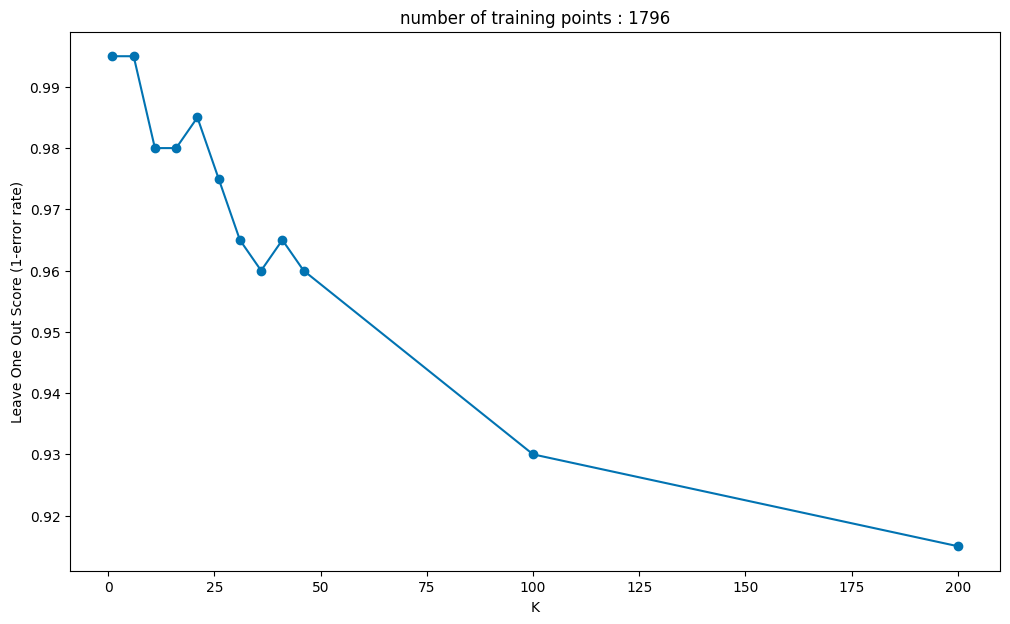

In [85]:
figure(figsize=(12, 7))
courbe = LOOCurve(k_range=[1,6,11,16,21,26,31,36,41,46,100,200], weights='uniform')
courbe.fit_curve(X, y, n_iter=200, random_state=1)
courbe.plot()

# Analyse Discriminante Linéaire

## Aspect théorique

On considère deux populations gaussiennes dans ${R}^{p}$ ayant la même structure de covariance. On
observe des points dans le mélange de ces deux populations.

Les lois conditionnelles de X sachant Y = +1 (respectivement Y = −1) sont des gaussiennes multivariées ${N}_{p}({µ}_{+}, Σ)$ (respectivement ${N}_{p}({µ}_{-}, Σ)$). On notera leurs densités respectives ${f}_{+}$ et ${f}_{-}$. Les vecteurs
${µ}_{+}$ et ${µ}_{+}$ sont dans ${R}^{p}$
et la matrice Σ est (symétrique) de taille p×p. On note également ${π}_{+} = P(\left\{Y = +1\right\}$.

### Question 15 :

En utilisant la formule de Bayes donner la formule des probabilités a posteriori : $P(\left\{Y = +1\right\}|\left\{X = x\right\})$, $P(\left\{Y = -1\right\}|\left\{X = x\right\})$, comme fonctions de ${f}_{+}$, ${f}_{-}$ et ${π}_{+}$.

On rappelle le théorème de Bayes :
    
$$ P(A \cap B) = P(B \cap A) = P(A|B).P(B) = P(B|A).P(A) $$

Donc :

$$ P(A|B) = \frac{P(B|A).P(A)}{P(B)} $$

On a aussi :

$$ P(B) = P(B \cap A) + P(B \cap \overline{A}) = P(B|A).P(A) + P(B|\overline{A}).P(\overline{A})$$

Donc :

$$ P(A|B) = \frac{P(B|A).P(A)}{P(B|A).P(A) + P(B|\overline{A}).P(\overline{A})} $$

En posant $A = \left\{Y = +1\right\}$, $\overline{A} = \left\{Y = -1\right\}$ et $B = \left\{X = x\right\}$ :

$$ P(\left\{Y = +1\right\}|\left\{X = x\right\}) = \frac{P(\left\{X = x\right\}|\left\{Y = +1\right\}).P(\left\{Y = +1\right\})}{P(\left\{X = x\right\})} $$

$$ P(\left\{Y = +1\right\}|\left\{X = x\right\}) = \frac{P(\left\{X = x\right\}|\left\{Y = +1\right\}).P(\left\{Y = +1\right\})}{P(\left\{X = x\right\}|\left\{Y = +1\right\}).P(\left\{Y = +1\right\}) + P(\left\{X = x\right\}|\left\{Y = -1\right\}).P(\left\{Y = -1\right\})} $$

Avec :

$ P(\left\{X = x\right\}|\left\{Y = +1\right\}) = {f}_{+} $

$ P(\left\{X = x\right\}|\left\{Y = -1\right\}) = {f}_{-} $

$ P(\left\{Y = +1\right\} = {π}_{+}$

$ P(\left\{Y = -1\right\} = 1 - {π}_{+}$

Donc :

$$ P(\left\{Y = +1\right\}|\left\{X = x\right\}) = \frac{{f}_{+}.{π}_{+}}{{f}_{+}.{π}_{+} + {f}_{-}.(1 - {π}_{+})}$$

De même, on a :

$$ P(\left\{Y = -1\right\}|\left\{X = x\right\}) = \frac{P(\left\{X = x\right\}|\left\{Y = -1\right\}).P(\left\{Y = -1\right\})}{P(\left\{X = x\right\}|\left\{Y = +1\right\}).P(\left\{Y = +1\right\}) + P(\left\{X = x\right\}|\left\{Y = -1\right\}).P(\left\{Y = -1\right\})} $$

Donc :

$$ P(\left\{Y = -1\right\}|\left\{X = x\right\}) = \frac{{f}_{-}.(1 - {π}_{+})}{{f}_{+}.{π}_{+} + {f}_{-}.(1 - {π}_{+})}$$

### Question 16 :

Exprimer le log-ratio des deux classes en fonction de ${π}_{+}$, ${µ}_{+}$, ${µ}_{-}$ et $Σ$ :

$$ log~\big(\frac{P(\left\{Y = +1\right\}|\left\{X = x\right\})}{P(\left\{Y = -1\right\}|\left\{X = x\right\})}\big) = log~\big(\frac{{f}_{+}.{π}_{+}}{{f}_{-}.(1 - {π}_{+})}\big) = log~({f}_{+}) + log~({π}_{+}) - log~({f}_{-}) - log~(1 - {π}_{+}) $$

Avec :

$$ {f}_{+} = \frac{1}{{(2π)}^{\frac{p}{2}}.\sqrt{det(Σ)}}~exp\left\{-\frac{1}{2}.{(x-{µ}_{+})}^{T}.{Σ}^{-1}.(x-{µ}_{+})\right\} $$

$$ {f}_{-} = \frac{1}{{(2π)}^{\frac{p}{2}}.\sqrt{det(Σ)}}~exp\left\{-\frac{1}{2}.{(x-{µ}_{-})}^{T}.{Σ}^{-1}.(x-{µ}_{-})\right\} $$

Donc :

$$ log~\big(\frac{P(\left\{Y = +1\right\}|\left\{X = x\right\})}{P(\left\{Y = -1\right\}|\left\{X = x\right\})}\big) = -\frac{1}{2}.\big({(x-{µ}_{+})}^{T}.{Σ}^{-1}.(x-{µ}_{+}) - {(x-{µ}_{-})}^{T}.{Σ}^{-1}.(x-{µ}_{-})\big) + log~\big(\frac{{π}_{+}}{1 - {π}_{+}}\big) $$

### Question 17 :

Justifier le choix du classifieur suivant :

$$
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad {x}^{T}.{\hat{Σ}}^{-1}.({\hat{µ}}_{+} - {\hat{µ}}_{-}) > \frac{1}{2}.{\hat{µ}}_{+}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{+} - \frac{1}{2}.{\hat{µ}}_{-}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{-} + log(1 - \frac{m}{n}) - log(\frac{m}{n}) \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

On a :
    
$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad P(\left\{Y = +1\right\}|\left\{X = x\right\}) > P(\left\{Y = -1\right\}|\left\{X = x\right\}) \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

Donc :

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad \frac{P(\left\{Y = +1\right\}|\left\{X = x\right\})}{P(\left\{Y = -1\right\}|\left\{X = x\right\})} > 1 \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

D'où :

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad log~\big(\frac{P(\left\{Y = +1\right\}|\left\{X = x\right\})}{P(\left\{Y = -1\right\}|\left\{X = x\right\})}\big) > 0 \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

D'après le résultat de la question 16 :

$$ log~\big(\frac{P(\left\{Y = +1\right\}|\left\{X = x\right\})}{P(\left\{Y = -1\right\}|\left\{X = x\right\})}\big) = -\frac{1}{2}.\big({(x-{µ}_{+})}^{T}.{Σ}^{-1}.(x-{µ}_{+}) - {(x-{µ}_{-})}^{T}.{Σ}^{-1}.(x-{µ}_{-})\big) + log~\big(\frac{{π}_{+}}{1 - {π}_{+}}\big) $$

Et en utilisant les estimateurs sans biais ${\hat{π}}_{+}$, ${\hat{µ}}_{+}$, ${\hat{µ}}_{-}$ et $\hat{Σ}$ :

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad -\frac{1}{2}.\big({(x-{\hat{µ}}_{+})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{+}) - {(x-{\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{-})\big) + log~\big(\frac{{\hat{π}}_{+}}{1 - {\hat{π}}_{+}}\big) > 0 \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

Avec : $\hat{π}_{+} = \frac{m}{n} $

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad -\frac{1}{2}.\big({(x-{\hat{µ}}_{+})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{+}) - {(x-{\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{-})\big) > log~(1-\frac{m}{n}) - log~(\frac{m}{n}) \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

On a :

$$ -\frac{1}{2}.\big({(x-{\hat{µ}}_{+})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{+}) - {(x-{\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{-})\big) = -\frac{1}{2}.\big({x}^{T}.\hat{Σ}^{-1}.x - {x}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{+} - {\hat{µ}}_{+}^{T}.\hat{Σ}^{-1}.x + {\hat{µ}}_{+}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{+}
\newline - {x}^{T}.\hat{Σ}^{-1}.x + {x}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{-} + {\hat{µ}}_{-}^{T}.\hat{Σ}^{-1}.x - {\hat{µ}}_{-}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{-}\big) $$

Donc :

$$ -\frac{1}{2}.\big({(x-{\hat{µ}}_{+})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{+}) - {(x-{\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{-})\big) = \frac{1}{2}.\big({x}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{+} + {\hat{µ}}_{+}^{T}.\hat{Σ}^{-1}.x - {\hat{µ}}_{+}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{+}
\newline - {x}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{-} - {\hat{µ}}_{-}^{T}.\hat{Σ}^{-1}.x + {\hat{µ}}_{-}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{-}\big) $$

$$ -\frac{1}{2}.\big({(x-{\hat{µ}}_{+})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{+}) - {(x-{\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.(x-{\hat{µ}}_{-})\big) = \frac{1}{2}.\big({x}^{T}.\hat{Σ}^{-1}.({\hat{µ}}_{+} - {\hat{µ}}_{-}) + {({\hat{µ}}_{+} - {\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.x - {\hat{µ}}_{+}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{+}
\newline + {\hat{µ}}_{-}^{T}.\hat{Σ}^{-1}.{\hat{µ}}_{-}\big) $$

Ainsi :

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad \frac{1}{2}.{x}^{T}.\hat{Σ}^{-1}.({\hat{µ}}_{+} - {\hat{µ}}_{-}) + \frac{1}{2}.{({\hat{µ}}_{+} - {\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.x > \frac{1}{2}.{\hat{µ}}_{+}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{+} - \frac{1}{2}.{\hat{µ}}_{-}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{-} + log(1 - \frac{m}{n}) - log(\frac{m}{n}) \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

Or : 

$$ {x}^{T}.\hat{Σ}^{-1}.({\hat{µ}}_{+} - {\hat{µ}}_{-}) = {({\hat{µ}}_{+} - {\hat{µ}}_{-})}^{T}.\hat{Σ}^{-1}.x \quad \text{car Σ est symétrique} $$

Donc, on retrouve :

$$
\hat{f}(x) = 
\begin{cases}
    \begin{split}
    1 & \quad \text{si} \quad {x}^{T}.{\hat{Σ}}^{-1}.({\hat{µ}}_{+} - {\hat{µ}}_{-}) > \frac{1}{2}.{\hat{µ}}_{+}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{+} - \frac{1}{2}.{\hat{µ}}_{-}^{T}.{\hat{Σ}}^{-1}.{\hat{µ}}_{-} + log(1 - \frac{m}{n}) - log(\frac{m}{n}) \\
    -1 & \quad \text{sinon}
    \end{split}
\end{cases}
$$

## Mise en œuvre

### Question 18 :

Écrivez votre propre classe <b>LDAClassifier</b> avec les méthodes d’apprentissage fit et de classification
predict

In [86]:
class LDAClassifier():

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n, n_features = X.shape
        # On change l'ordre des xi et des yi (pour pouvoir regrouper les classes)
        X_ = X[y.argsort(),:]
        y_ = np.sort(y)
        # Nombre d'observations dans chaque classe
        counts = np.unique(y, return_counts=True)[1]
        # Classes
        self.classes = np.unique(y, return_counts=True)[0]
        # Nombre de classes (on est dans le cas d'une classification binaire, donc n_classes = 2)
        n_classes = len(counts)
        # Nombre d'observations dans la première classe
        m = counts[0]
        # X1 et X2
        X1 = X_[range(0,m),:] ## ==> Nombre d'observations = m
        X2 = X_[range(m,n),:] ## ==> Nombre d'observations = n - m
        # Moyennes empiriques
        µ1 = np.mean(X1, axis=0)
        µ2 = np.mean(X2, axis=0)
        # Matrice de covariance
        Cov1 = np.cov(X1.T)
        Cov2 = np.cov(X2.T)
        Cov = ((m-1)*Cov1 + (n-m-1)*Cov2) / (n-2)
        Cov_inv = np.linalg.inv(Cov)
        # Multiplicateurs
        self.M_g = Cov_inv@(µ1 - µ2)
        self.M_d = 0.5*(µ1.T)@Cov_inv@µ1 - 0.5*(µ2.T)@Cov_inv@µ2 + np.log(1 - m/n) - np.log(m/n)
        return self
    
    def predict(self, X):
        self.X_test = X
        pred = np.array([])
        for i in range(len(X)):
            if X[i]@self.M_g > self.M_d:
                pred = np.append(pred, self.classes[0])
            else:
                pred = np.append(pred, self.classes[1])
        return pred
    
    def score(self, X, y):
        self.X_test = X
        self.y_test = y
        y_pred = self.predict(self.X_test)
        accuracy = np.sum(y_pred == self.y_test) / len(self.y_test)
        return accuracy

### Question 19 :

Importez le module <b>sklearn.discriminant_analysis</b> qui contient en particulier la classe
<b>LinearDiscriminantAnalysis</b> qui nous servira dans la suite

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe
<b>LinearDiscriminantAnalysis</b> de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m,
i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez
les taux d’erreur de <b>LDAClassifier</b> et de <b>LinearDiscriminantAnalysis</b> et le nombre de cas où les
prédictions coïncident.

In [88]:
X_train, y_train = rand_bi_gauss(n1=30, n2=50, 
                                 mu1=[1, 1], mu2=[-1, -1], 
                                 sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

X_test, y_test = rand_bi_gauss(n1=1000, n2=1000, 
                               mu1=[1, 1], mu2=[-1, -1], 
                               sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

In [89]:
lda_classifier = LDAClassifier()
lda_sklearn = LinearDiscriminantAnalysis()

lda_classifier.fit(X_train, y_train)
lda_sklearn.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
y_pred_skl = lda_sklearn.predict(X_test)

print("Taux d'erreur avec LDAClassifier : "+str(1 - lda_classifier.score(X_test, y_test)))
print("Taux d'erreur avec LinearDiscriminantAnalysis : "+str(1 - lda_sklearn.score(X_test, y_test)))
print('Les prédictions coïncident dans {} cas parmi {}.'.format((y_pred == y_pred_skl).sum(), y_test.shape[0]))

Taux d'erreur avec LDAClassifier : 0.08699999999999997
Taux d'erreur avec LinearDiscriminantAnalysis : 0.08699999999999997
Les prédictions coïncident dans 2000 cas parmi 2000.


En utilisant votre classe <b>LDAClassifier</b>, visualisez la règle de classification.

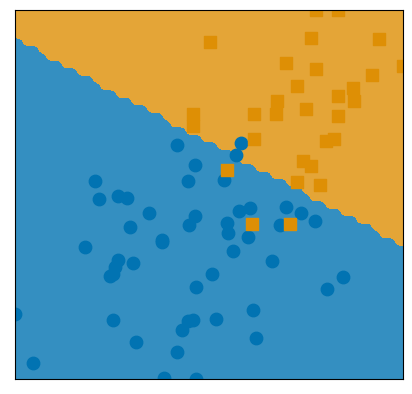

In [90]:
def f_(X):
    return lda_classifier.predict(X.reshape(1,-1))

frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

### Question 20 :

En utilisant votre classe <b>LDAClassifier</b>, visualisez la règle de classification pour les jeux de données
#1 et #3. Discutez l’efficacité de la méthode
dans ces deux cas

➤ dataset_1 :

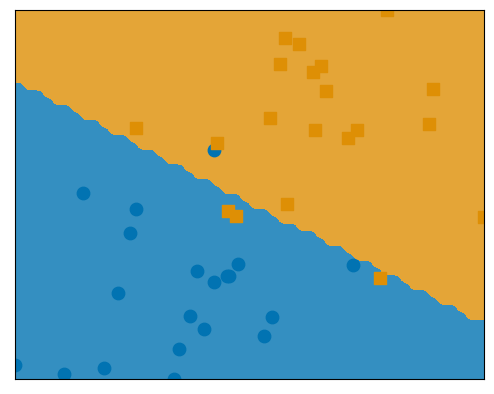

In [91]:
lda_classifier = LDAClassifier()
lda_classifier.fit(dataset_1[0], dataset_1[1])

def f_(X):
    return lda_classifier.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_1[0], dataset_1[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

➤ dataset_3 :

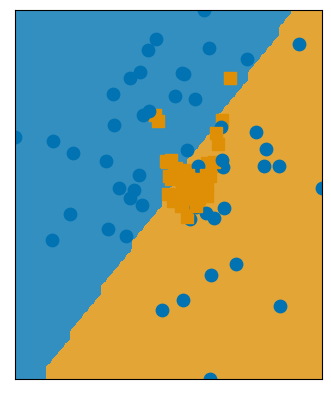

In [92]:
lda_classifier = LDAClassifier()
lda_classifier.fit(dataset_3[0], dataset_3[1])

def f_(X):
    return lda_classifier.predict(X.reshape(1,-1))

frontiere_new(f_, dataset_3[0], dataset_3[1], w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

On remarque clairement que cette méthode fonctionne très bien sur des données linéairement séparables (dataset 1), mais pas sur des données non linéairement séparables (dataset 3).

# Régression logistique

## Méthode discriminative avec régression logistique

Importer le module sklearn.linear_model qui contient en particulier la classe <b>LogisticRegression</b>
qui nous servira dans la suite.

In [93]:
from sklearn import linear_model

### Question 21 :

Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les
résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

In [94]:
X_train, y_train = rand_bi_gauss(n1=18, n2=130, 
                                 mu1=[1, 1], mu2=[-1, -1], 
                                 sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

X_test, y_test = rand_bi_gauss(n1=1000, n2=1000, 
                               mu1=[1, 1], mu2=[-1, -1], 
                               sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

In [95]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.8695

In [96]:
lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X_train, y_train)
lda_sklearn.score(X_test, y_test)

0.889

Les deux méthodes donnent à peu près les mêmes résultats (les scores sont très proches).

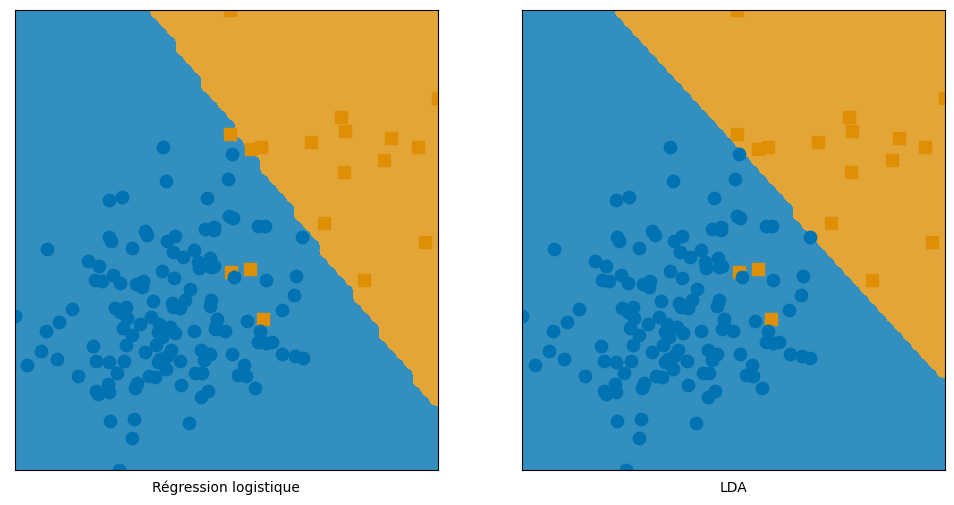

In [97]:
figure(figsize=(12,7))
plt.subplot(1, 2, 1)
plt.xlabel("Régression logistique", fontsize=10)
def f_(X):
    return logreg.predict(X.reshape(1,-1))
frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

plt.subplot(1, 2, 2)
plt.xlabel("LDA", fontsize=10)
def f_(X):
    return lda_sklearn.predict(X.reshape(1,-1))
frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=False, samples=True)

### Question 22 :

À quoi correspond la variable coef_ du modèle ? intercept_ ?

In [98]:
logreg.coef_

array([[1.85174841, 1.32048161]])

In [99]:
logreg.intercept_

array([-1.69305032])

$$ P = P(\left\{Y = +1\right\} | X) = \frac{exp~({β}_{0} + {β}_{1}.{X}_{1} + {β}_{2}.{X}_{2})}{1 + exp~({β}_{0} + {β}_{1}.{X}_{1} + {β}_{2}.{X}_{2})} $$

Donc :

$$ log~\big(\frac{P}{1 - P}\big) = {β}_{0} + {β}_{1}.{X}_{1} + {β}_{2}.{X}_{2} $$

En effet :

$$ \text{coef_ correspond à }[{β}_{1} , {β}_{2}]\text{, tandis que intercept_ correspond à }{β}_{0} $$

### Question 23 :

Utiliser la fonction frontiere_new pour visualiser la frontière de décision.

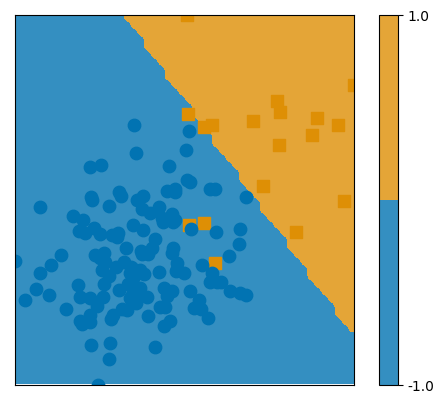

In [100]:
def f_(X):
    return logreg.predict(X.reshape(1,-1))
frontiere_new(f_, X_train, y_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

### Question 24 :

Appliquez la classification par régression logistique à des données issues de la base digits. Comme
précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie
pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.

In [101]:
digits = datasets.load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, shuffle=False)

In [102]:
logreg = linear_model.LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
print("Accuracy = "+str(round(logreg.score(X_test, y_test),4)))
print("Taux d'erreur = "+str(round(1 - logreg.score(X_test, y_test),4)))

Accuracy = 0.9321
Taux d'erreur = 0.0679


In [103]:
metrics = precision_recall_fscore_support(y_test, logreg.predict(X_test), warn_for=tuple())
list_metrics = ['Precision', 'Recall', 'F1-score', 'Support']

print(tabulate([[list_metrics[i], 
                 np.round(metrics[i][0],4), 
                 np.round(metrics[i][1],4), 
                 np.round(metrics[i][2],4),
                 np.round(metrics[i][3],4),
                 np.round(metrics[i][4],4),
                 np.round(metrics[i][5],4),
                 np.round(metrics[i][6],4),
                 np.round(metrics[i][7],4),
                 np.round(metrics[i][8],4),
                 np.round(metrics[i][9],4)]
                for i in range(4)], 
               headers=['Métrique','0','1','2','3','4','5','6','7','8','9']))

Métrique          0        1        2        3        4        5        6        7        8        9
----------  -------  -------  -------  -------  -------  -------  -------  -------  -------  -------
Precision    0.9884   0.9639   0.9882   0.9625   0.977    0.8969   0.9184   0.9659   0.8667   0.8286
Recall       0.9659   0.8791   0.9767   0.8462   0.9239   0.956    0.989    0.9551   0.8864   0.9457
F1-score     0.977    0.9195   0.9825   0.9006   0.9497   0.9255   0.9524   0.9605   0.8764   0.8832
Support     88       91       86       91       92       91       91       89       88       92


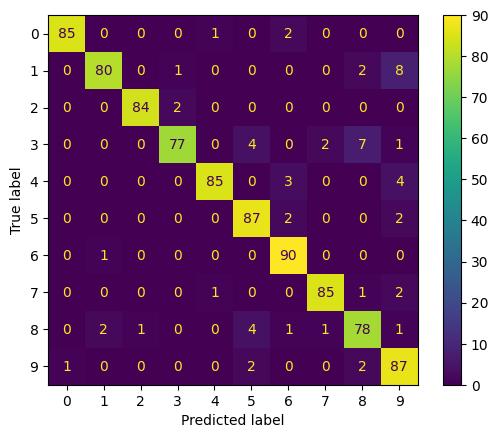

In [104]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)